In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
train_dir = "/content/drive/MyDrive/FruitinAmazon/train"
test_dir = "//content/drive/MyDrive/FruitinAmazon/test"

In [ ]:
import os
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [ ]:

corrupted_images = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)


if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")



No corrupted images found.


In [ ]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


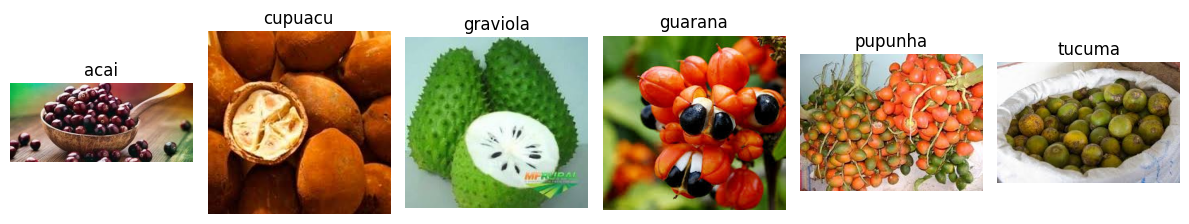

In [ ]:
selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
fig, axes = plt.subplots(1,num_classes, figsize=(12,6))

if num_classes == 1:
    axes = [axes]

for ax, img_path, label in zip(axes, selected_images, selected_labels):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
img_height = 224
img_width = 224
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
from tensorflow.keras.layers import LeakyReLU

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.15)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,0

 Total params: 491,334 (1.87 MB)

 Trainable params: 489,606 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    epochs=250,
    batch_size = batch_size,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.3252 - loss: 1.9535

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 7s/step - accuracy: 0.3242 - loss: 1.9576 - val_accuracy: 0.2333 - val_loss: 1.7820
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.4377 - loss: 1.7159 - val_accuracy: 0.1667 - val_loss: 1.7738
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.3390 - loss: 1.7935 - val_accuracy: 0.1667 - val_loss: 1.7660
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.5334 - loss: 1.3541 - val_accuracy: 0.2000 - val_loss: 1.7596
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.5422 - loss: 1.2404 - val_accuracy: 0.2000 - val_loss: 1.7618
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.5431 - loss: 1.2609 - val_accuracy: 0.2333 - val_loss: 1.7668
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.6053 - loss: 1.1371 - val_accuracy: 0.2333 - val_loss: 1.7747
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6314 - loss: 1.1332

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - accuracy: 0.6284 - loss: 1.1375 - val_accuracy: 0.2667 - val_loss: 1.7794
Epoch 9/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - accuracy: 0.5905 - loss: 1.1574 - val_accuracy: 0.2333 - val_loss: 1.7856
Epoch 10/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - accuracy: 0.5905 - loss: 1.0847 - val_accuracy: 0.2333 - val_loss: 1.7879


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2000 - loss: 1.7596
Test accuracy: 0.2000
Test loss: 1.7596


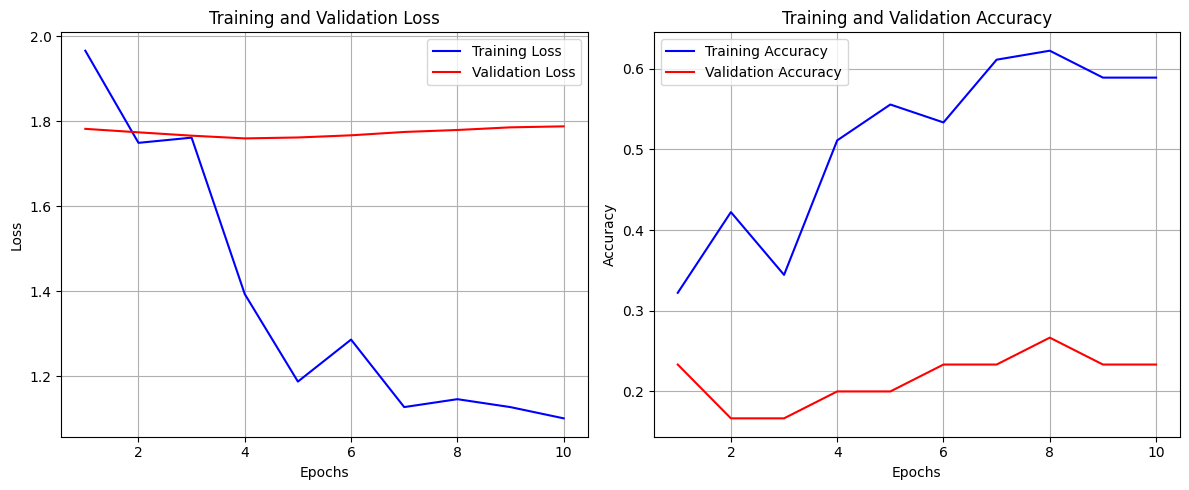

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
model.save('RohitPrajapati_w6_task1.h5')
print("Model saved as 'RohitPrajapati_w6_task1.h5'")

Model saved as 'RohitPrajapati_w6_task1.h5'


In [ ]:
loaded_model = tf.keras.models.load_model('RohitPrajapati_w6_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step - accuracy: 0.2000 - loss: 1.7596
Loaded model test accuracy: 0.2000
Loaded model test loss: 1.7596


In [ ]:
loaded_model = keras.models.load_model('RohitPrajapati_w6_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.25      0.20      0.22         5
    graviola       0.19      1.00      0.32         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.20        30
   macro avg       0.07      0.20      0.09        30
weighted avg       0.07      0.20      0.09        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1892 - loss: 6.0808  

2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 31s/step - accuracy: 0.2002 - loss: 6.2070 - val_accuracy: 0.3667 - val_loss: 7.2859
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5545 - loss: 5.1758

2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 602ms/step - accuracy: 0.5623 - loss: 4.9975 - val_accuracy: 0.5667 - val_loss: 2.6720
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7750 - loss: 1.7984

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step - accuracy: 0.7833 - loss: 1.7097 - val_accuracy: 0.7000 - val_loss: 1.3078
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9677 - loss: 0.1313

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step - accuracy: 0.9674 - loss: 0.1292 - val_accuracy: 0.7333 - val_loss: 1.2339
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.9377 - loss: 0.2282 - val_accuracy: 0.6333 - val_loss: 1.8871
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.9473 - loss: 0.1963 - val_accuracy: 0.7000 - val_loss: 1.8031
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step - accuracy: 0.9874 - loss: 0.0496 - val_accuracy: 0.7333 - val_loss: 1.6251
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.7333 - val_loss: 1.5931
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.7333 - val_loss: 1.6429
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.6667 - val_loss: 1.7524
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.6667 - val_loss: 1.8741
E

In [ ]:
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7333 - loss: 1.2339
Test accuracy for VGG16: 0.7333


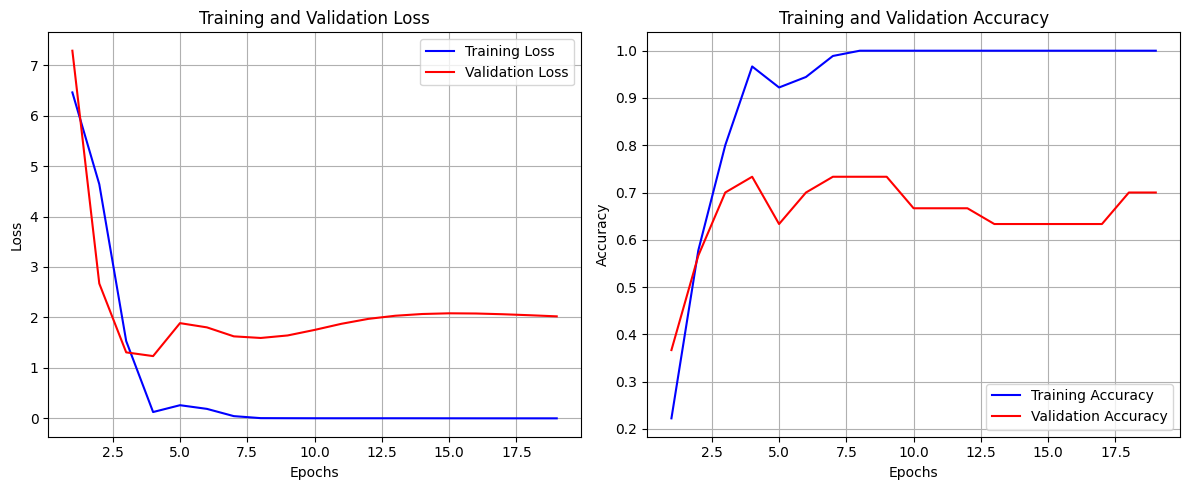

In [ ]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.67      0.80      0.73         5
     cupuacu       0.62      1.00      0.77         5
    graviola       1.00      0.60      0.75         5
     guarana       0.83      1.00      0.91         5
     pupunha       0.60      0.60      0.60         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.73        30
   macro avg       0.79      0.73      0.72        30
weighted avg       0.79      0.73      0.72        30

